In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math

from votekit.ballot import Ballot
from fractions import Fraction
# from votekit.pref_profile import PreferenceProfile

from votekit.plots import plot_summary_stats
import votekit.ballot_generator as bg

from votekit.graphs import PairwiseComparisonGraph
from votekit.elections import Plurality, DominatingSets, IRV 

from scipy.stats import gaussian_kde
import seaborn as sns

In [27]:
# Helper Functions

def softmax(x, temperature=0.8):
    e_x = np.exp((x - np.max(x)) / temperature)  # Subtract max for numerical stability and divide by temperature
    return e_x / e_x.sum()

def distances_to_probabilities(distances_dict, temperature=1.0):
    # Extract the values and convert them to a list
    values_list = list(distances_dict.values())
    
    # Convert the list to a NumPy array
    values_array = np.array(values_list)
    
    # Apply the softmax function to the negated distances with temperature
    probabilities = softmax(-values_array, temperature)  # Negate to give higher probability to smaller distances
    
    # Create a new dictionary with probabilities
    probability_distribution = {key: prob for key, prob in zip(distances_dict.keys(), probabilities)}
    
    return probability_distribution

def plot_colored_histogram(y):
    # Create a custom colormap from red to blue
    colors = [(0, 0, 1), (1, 0, 0)]  # Red to Blue
    n_bins = 100  # Number of bins

    # Create the custom colormap
    cmap = LinearSegmentedColormap.from_list("RedBlue", colors, N=n_bins)

    # Create the histogram
    n, bins, patches = plt.hist(y, bins=n_bins, edgecolor='black')

    # Normalize the data to [0, 1] for the colormap
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    # Apply the colors to the histogram
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Voters')
    plt.show()

def simulateBallot(dict_prob, l):
    """
    Simulates a ballot based on probabilites from a dictionary and the length of a ballot. We sample w/o replacement

    Example dict: 
    {'A': 0.2426514747465432,
     'B': 0.17313196855243765,
     'C': 0.2135050402872638,
     'D': 0.19728230610335315,
     'E': 0.09381626602650525,
     'F': 0.07961294428389709}
    
    We have 6 candidates, with probabilites being picked on the ballot.  
    """

    keys = list(dict_prob.keys())
    probabilities = list(dict_prob.values())

    if l > len(keys):
        raise ValueError("Number of samples requested exceeds the number of available keys.")

    # this here can be doing something weird... 
    sampled_cand = np.random.choice(keys, size=l, replace=False, p=probabilities)

    # Return as ballot format

    cast_record = [{vote} for vote in sampled_cand]
    ballot = Ballot(ranking = cast_record)
    
    return ballot

####### EDITING VOTEKIT FUNCTIONS #######

from matplotlib import pyplot as plt  # type: ignore
from votekit.pref_profile import PreferenceProfile
from votekit.utils import first_place_votes, mentions, COLOR_LIST, borda_scores

def plot_summary_stats(
    profile: PreferenceProfile, stat: str, multi_color: bool = True, title: str = ""
):
    """
    Plots histogram of election summary statistics.

    Args:
        profile (PreferenceProfile): A ``PreferenceProfile`` to visualize.
        stat (str): 'first place votes', 'mentions', or 'borda'.
        multi_color (bool, optional): If the bars should be multicolored. Defaults to True.
        title (str, optional): Title for the figure. Defaults to empty string.

    Returns:
        Figure: A ``matplotlib`` figure with the visualization.
    """
    stats = {
        "first place votes": first_place_votes,
        "mentions": mentions,
        "borda": borda_scores,
    }

    stat_func = stats[stat]
    data: dict = stat_func(profile)  # type: ignore

    if multi_color:
        colors = COLOR_LIST[: len(list(data.keys()))]
    else:
        colors = [COLOR_LIST[-1]]

    fig, ax = plt.subplots()

    candidates = sorted(profile.get_candidates(received_votes=False))
    y_data = [data[c] for c in candidates]
    
    ax.bar(candidates, y_data, color=colors, width=0.35)
    ax.set_xlabel("Candidates")
    ax.set_ylabel("Frequency")

    if title:
        ax.set_title(title)

    return fig

def simulateProfile(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters (bimodal)
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        dict_ballot[i] = simulateBallot(distances[i], 4)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

def kdeBallotSampler(kde):
    numberBallots = 10000
    resampled_data = kde.resample(size=numberBallots).flatten()
    candidates = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

    temperature = 0.15 
    
    distances = {}

    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(resampled_data[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # For now sample uniformly from a length

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        dict_ballot[i] = simulateBallot(distances[i], 5)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candidates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

def simulateProfileUniform(plot = False):
    numberBallots = 10000
    y = np.random.random(numberBallots)

    if plot == True: 
        plot_colored_histogram(y)
        
    candidates = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

    temperature = 0.15 
    
    distances = {}

    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # For now sample uniformly from a length

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        dict_ballot[i] = simulateBallot(distances[i], 5)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candidates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

In [33]:
def runGeneration(epoch=100000, t=10, plot = False):
    """
    Runs a generation based on a starting distribution of length epoch for t generations
    """
    candidate_win_distribution_epoch0 = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
    for i in range(epoch):
        if i % 100 == 0:
            print(f"Finished run {i}")
        profile = simulateProfileUniform(False)
        electionIRV = IRV(profile = profile)
        state = electionIRV.run_election()
        candidate_win_distribution_epoch0[next(iter(state.winners()[0]))] += 1

    # Expand the data according to the frequencies
    frequencies = candidate_win_distribution_epoch0
    data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}
    
    expanded_data = []
    for category, freq in frequencies.items():
        expanded_data.extend([data[category]] * freq)

    kde = gaussian_kde(expanded_data, bw_method=0.3)

    # Create an array of values for the x-axis
    x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
    kde_values = kde(x)
    
    if plot == True: 
        # Plot the histogram and KDE
        plt.figure(figsize=(10, 6))
        sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
        plt.plot(x, kde_values, color='blue')

    data_dict = {}
    data_dict['candidate_win_distribution_epoch0'] = candidate_win_distribution_epoch0
    for i in range(1, t):
        candidate_win_distribution_current_epoch = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
        print(f"Finished run {i}")
        for j in range(epoch):
            profile = kdeBallotSampler(kde)
            electionIRV = IRV(profile = profile)
            state = electionIRV.run_election()
            candidate_win_distribution_current_epoch[next(iter(state.winners()[0]))] += 1
        data_dict[f'candidate_win_distribution_epoch{i}'] = candidate_win_distribution_current_epoch

        frequencies = candidate_win_distribution_current_epoch
        data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

        # Expand the data according to the frequencies
        expanded_data = []
        for category, freq in frequencies.items():
            expanded_data.extend([data[category]] * freq)

        kde = gaussian_kde(expanded_data, bw_method=0.3)

        if plot == True: 
            # Create an array of values for the x-axis
            x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
            kde_values = kde(x)

            # Plot the histogram and KDE
            plt.figure(figsize=(10, 6))
            sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
            plt.plot(x, kde_values, color='blue')
    return data_dict

Finished run 0
Finished run 100
Finished run 200
Finished run 300
Finished run 400
Finished run 500
Finished run 600
Finished run 700
Finished run 800
Finished run 900
Finished run 1
Finished run 2
Finished run 3
Finished run 4
Finished run 5
Finished run 6
Finished run 7
Finished run 8
Finished run 9


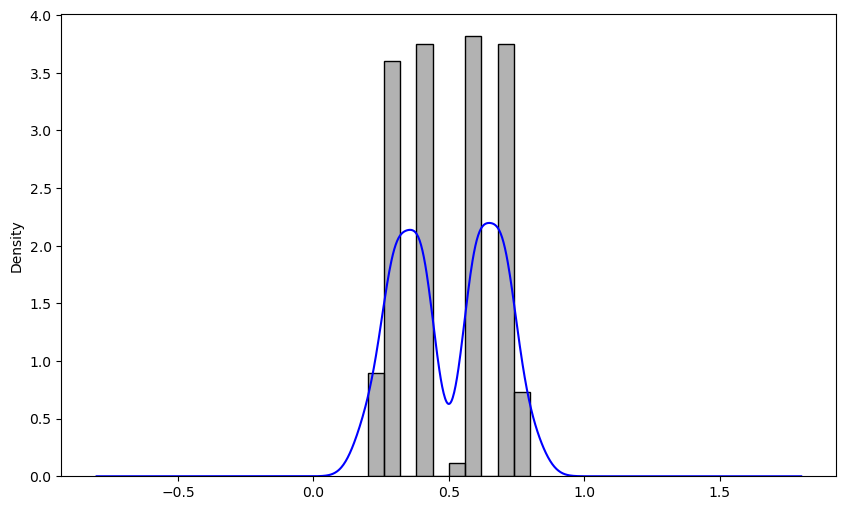

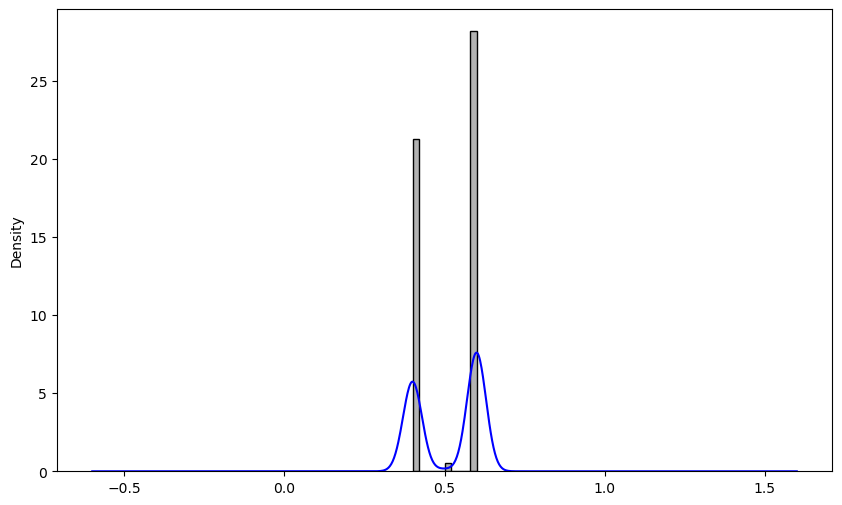

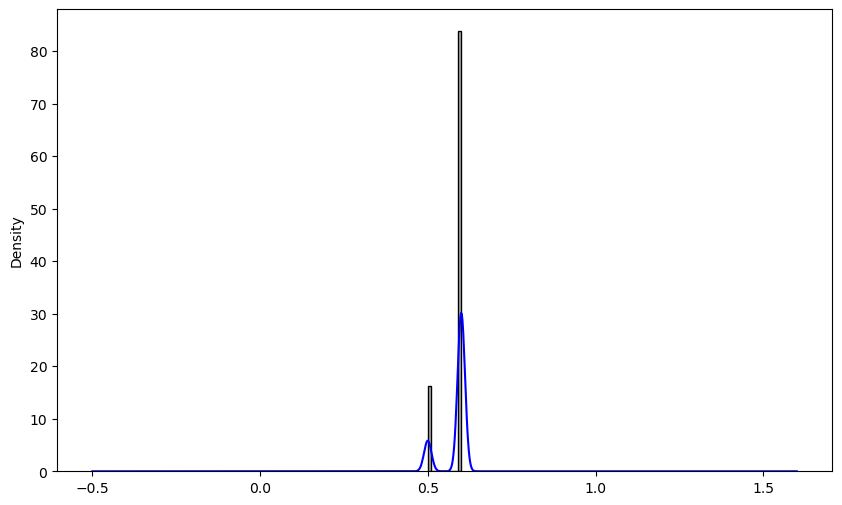

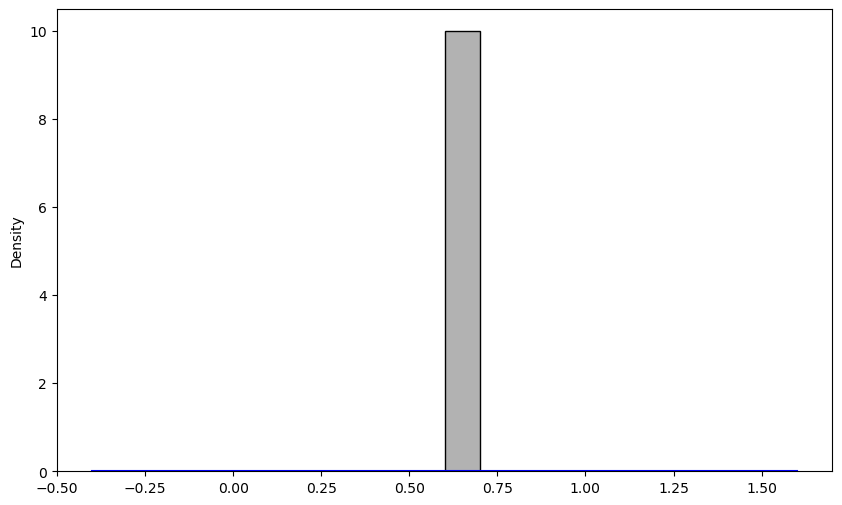

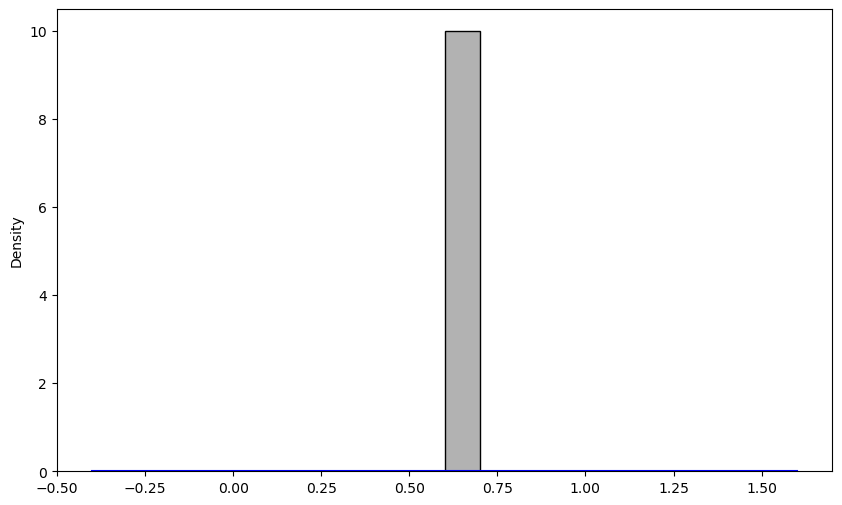

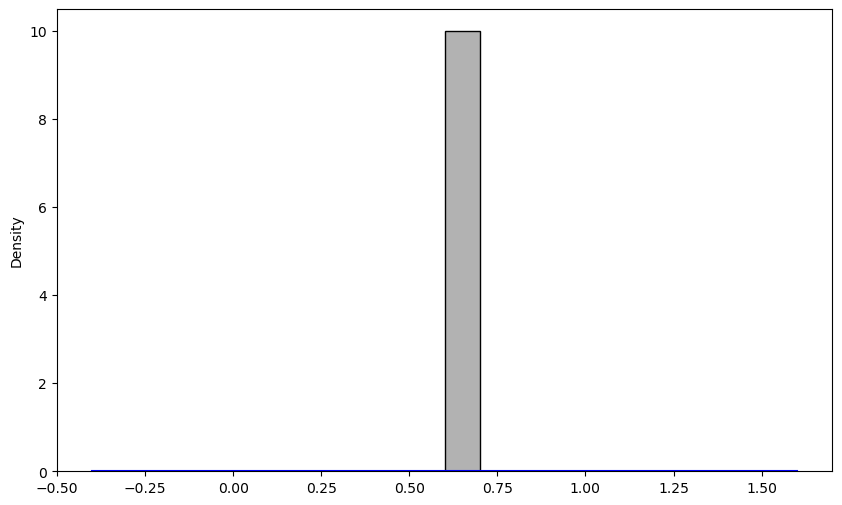

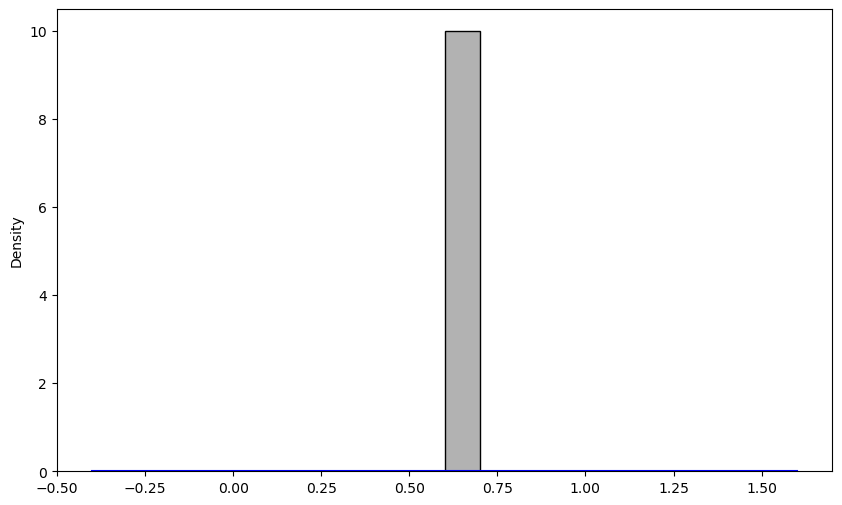

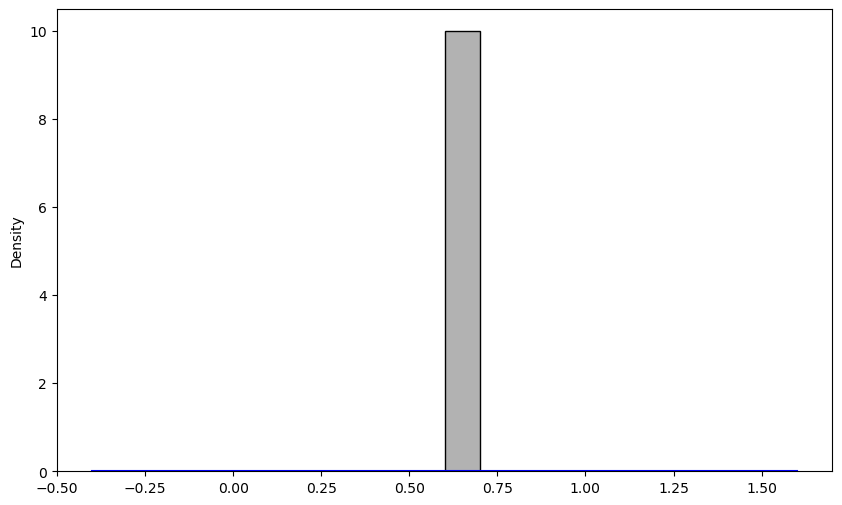

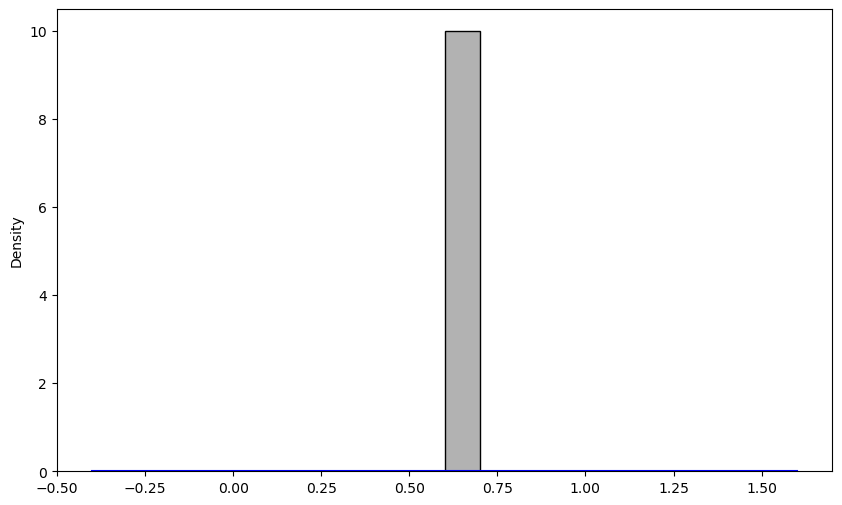

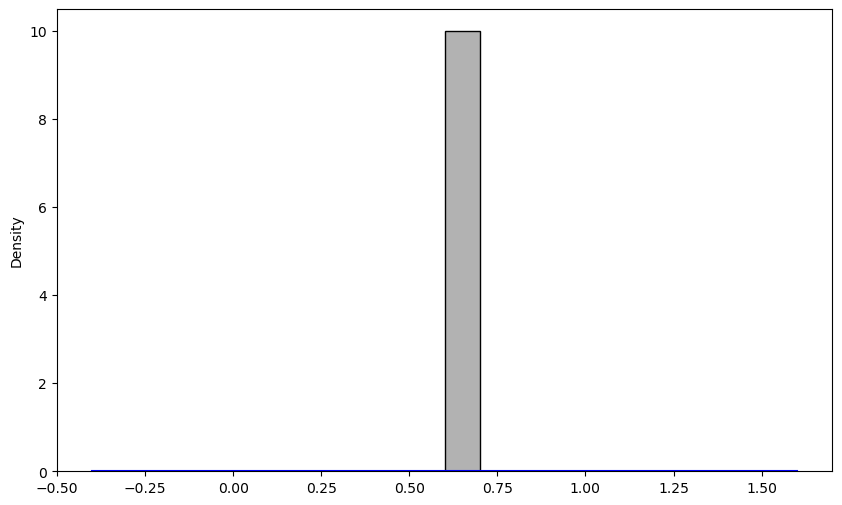

In [34]:
data = runGeneration(1000, 10, True)

Finished run 0
Finished run 100
Finished run 200
Finished run 300
Finished run 400
Finished run 500
Finished run 600
Finished run 700
Finished run 800
Finished run 900


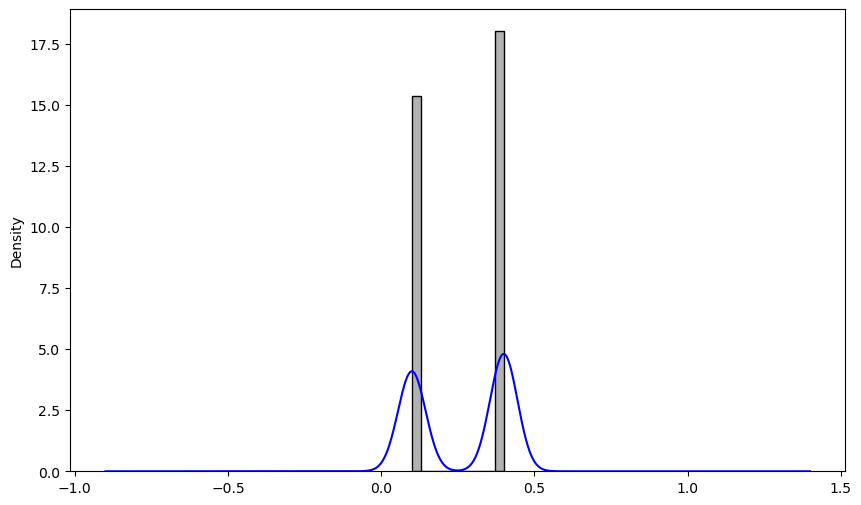

In [5]:
## First goal: assuming an initially polarized voter base, how do the voters evolve over time where the 
## voters adopt the winning candidate's distribution? 

## Assuming a fixed ballot length of k = 3, would be interesting to add even more candidates 

# The first one will be done manually 
candidate_win_distribution_epoch0 = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
for i in range(epoch):
    if i % 100 == 0:
        print(f"Finished run {i}")
    profile = simulateProfile()
    electionIRV = IRV(profile = profile)
    state = electionIRV.run_election()
    candidate_win_distribution_epoch0[next(iter(state.winners()[0]))] += 1

frequencies = candidate_win_distribution_epoch0
data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

# Expand the data according to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

kde = gaussian_kde(expanded_data, bw_method=0.3)

# Create an array of values for the x-axis
x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
kde_values = kde(x)

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
plt.plot(x, kde_values, color='blue')